In [18]:
import os.path
%matplotlib inline
import torch
import numpy as np
import yaml
from pytorch3d.ops import knn_points
from pytorch3d.loss import chamfer_distance
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.animation import FuncAnimation, FFMpegWriter

def calculate_differentiable_smoothness(centers_array, vectors_array):
    num_centers = centers_array.shape[0]
    vectors_number = vectors_array.shape[0]
    indices = torch.zeros(vectors_number, 3, dtype=torch.int64)
    for i in range(vectors_number):
        mask = np.ones(num_centers, dtype=bool)
        mask[i] = False
        new_centers_array = centers_array[mask].clone().detach()
        new_centers_array = new_centers_array.reshape(1, -1, 3)
        centers_array_i = (centers_array[i] + vectors_array[i]).reshape(1, -1, 3)
        _, idx, _ = knn_points(centers_array_i, new_centers_array, K=2)
        idx = idx[0][0][0]
        if idx >= i:
            idx += 1
        indices[i, :] = idx
    vec = torch.zeros(num_centers, 3)
    vec = vec.scatter_reduce(dim=0, index=indices, src=vectors_array, reduce='mean', include_self=False)
    res = torch.nn.functional.mse_loss(vectors_array, vec[indices[:, 0]], reduction='sum')
    return res


def calculate_continuity(centers_array, vectors_array):
    num_centers = centers_array.shape[0]
    vectors_number = vectors_array.shape[0]

    indices = torch.zeros(vectors_number, 3, dtype=torch.int64)
    for i in range(vectors_array.shape[0]):
        mask = np.ones(num_centers, dtype=bool)
        mask[i] = False
        new_centers_array = centers_array[mask].clone().detach()
        new_centers_array = new_centers_array.reshape(1, -1, 3)
        centers_array_i = (centers_array[i] + vectors_array[i]).reshape(1, -1, 3)
        _, idx, _ = knn_points(centers_array_i, new_centers_array, K=2)
        idx = idx[0][0][0]
        if idx >= i:
            idx += 1
        indices[i, :] = idx
    vec = vectors_array.mean(dim=0).repeat(vectors_number, 1)
    res = torch.nn.functional.mse_loss(vectors_array, vec, reduction='sum')
    return res


def vector_exclusivity(centers_array, vectors_array):
    num_centers = centers_array.shape[0]
    vectors_number = vectors_array.shape[0]

    indices = torch.zeros(vectors_number, dtype=torch.int64)
    for i in range(vectors_number):
        mask = np.ones(num_centers, dtype=bool)
        mask[i] = False
        new_centers_array = centers_array[mask].clone().detach()
        new_centers_array = new_centers_array.reshape(1, -1, 3)
        centers_array_i = (centers_array[i] + vectors_array[i]).reshape(1, -1, 3)
        _, idx, _ = knn_points(centers_array_i, new_centers_array, K=1)
        idx = idx[0][0][0]
        if idx >= i:
            idx += 1
        indices[i] = idx
    sum_of_losses = torch.tensor(0.0)
    for j in range(num_centers):
        mask = torch.nonzero(indices == j).flatten()
        if len(mask) > 1:
            pairs = torch.combinations(mask, r=2)
            index1, index2 = pairs.unbind(1)
            res = torch.nn.functional.mse_loss(
                vectors_array[index1],
                vectors_array[index2],
                reduction='sum'
            )
            sum_of_losses += res
    return sum_of_losses

def exclusivity_repulsion(centers_array, vectors_array):
    num_centers = centers_array.shape[0]
    vectors_number = vectors_array.shape[0]
    indices = torch.zeros(vectors_number, dtype=torch.int64)
    for i in range(vectors_number):
        mask = np.ones(num_centers, dtype=bool)
        mask[i] = False
        new_centers_array = centers_array[mask].clone().detach()
        new_centers_array = new_centers_array.reshape(1, -1, 3)
        centers_array_i = (centers_array[i] + vectors_array[i]).reshape(1, -1, 3)
        _, idx, _ = knn_points(centers_array_i, new_centers_array, K=1)
        idx = idx[0][0][0]
        if idx >= i:
            idx += 1
        indices[i] = idx
    sum_of_losses = torch.tensor(0.0)
    zero_vector = torch.zeros(3).reshape(-1, 3)
    for j in range(num_centers):
        mask = torch.nonzero(indices == j).flatten()
        if len(mask) > 1:
            pairs = torch.combinations(mask, r=2)
            index1, index2 = pairs.unbind(1)
            res = -torch.nn.functional.mse_loss(
                centers_array[j]-(centers_array[index1]+vectors_array[index1]),
                centers_array[j]-(centers_array[index2]+vectors_array[index2]),
                reduction='sum'
            )
            sum_of_losses += res
    return sum_of_losses
    
def pca_differ(vectors_array,initial_vectors):
    sum_of_losses = torch.tensor(0.0)
    vector_normal = torch.nn.functional.normalize(vectors_array)
    initial_vector_normal = torch.nn.functional.normalize(initial_vectors)
    for i in range(vectors_array.shape[0]):
        res = torch.nn.functional.mse_loss(vector_normal[i], initial_vector_normal[i], reduction='sum')
        sum_of_losses += res
    return sum_of_losses

                
def find_closest_direction(padded_centers_array, padded_vectors_directions):
    # with torch.no_grad():
    output_vector = torch.ones(padded_centers_array.shape[0], dtype=torch.bool)
    for i in range(padded_centers_array.shape[0]):
        print(output_vector[i])
        mask = np.ones(padded_centers_array.shape[0], dtype=bool)
        mask[i] = False
        new_centers_array = padded_centers_array[mask].clone().detach()
        new_centers_array = new_centers_array.reshape(1, -1, 3)
        centers_array_i = (padded_centers_array[i]+padded_vectors_directions[i]).reshape(1, -1, 3)
        _, idx, _ = knn_points(centers_array_i, new_centers_array, K=1)
        neighbours = idx
        
        # print(padded_vectors_directions[i])
        ex_idx = neighbours[0][0][0].item()
        if ex_idx >= i:
            ex_idx += 1
        #print(padded_centers_array[i])
        #print(padded_centers_array[ex_idx])
        
        point_in_half = (padded_centers_array[i] + ((1 / 2) * padded_vectors_directions[i]))
        new_direct = (1 / 2) * padded_vectors_directions[i]
        c = -torch.dot(new_direct, point_in_half)
        #print(point_in_half)
        #print(new_direct)
        #print(c)
        value_of_center = (new_direct[0] * padded_centers_array[i][0]) + (new_direct[1] * padded_centers_array[i][1]) + c
        value_of_togo = (new_direct[0] * padded_centers_array[ex_idx][0]) + (new_direct[1] * padded_centers_array[ex_idx][1]) + c
        #print(value_of_togo,value_of_center)
        if value_of_togo <= 0 and value_of_center <= 0 or value_of_togo >= 0 and value_of_center >= 0:
            output_vector[i] = False
    return output_vector


In [68]:
#example how to create points
"""
case = 4
centers = [(2.17741935483871, 4.989177489177489), (4.314516129032258, 5.097402597402598),
               (6.491935483870967, 4.989177489177489)]
vectors = [(2.338709677419355, 8.153679653679655), (4.556451612903226, 7.666666666666668),
               (6.653225806451613, 5.963203463203463)]  
np.savez("case"+str(case)+".npz", centers = centers, vectors = vectors)"""

In [69]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

case = config['case']
centers = None
vectors = None

with np.load("case"+str(case)+".npz") as data:
    loaded_centers = data['centers']
    centers = [tuple(float(item) for item in row) for row in loaded_centers ]
    loaded_vectors = data['vectors']
    vectors = [tuple(float(item) for item in row) for row in loaded_vectors ]

centers_array = torch.tensor(centers).detach()
vectors_directions = torch.tensor(vectors) - centers_array[:len(vectors)]
zero_z = torch.zeros(len(vectors_directions))
padded_vectors_directions = torch.column_stack((vectors_directions, zero_z))
padded_vectors_directions.requires_grad = True
zero_z = torch.zeros(len(centers_array))
padded_centers_array = torch.column_stack((centers_array, zero_z))
optimizer = torch.optim.SGD([padded_vectors_directions], lr=0.02)
if not os.path.exists('case'+str(case)):
    os.mkdir('case'+str(case))

MovieWriter imagemagick unavailable; using Pillow instead.


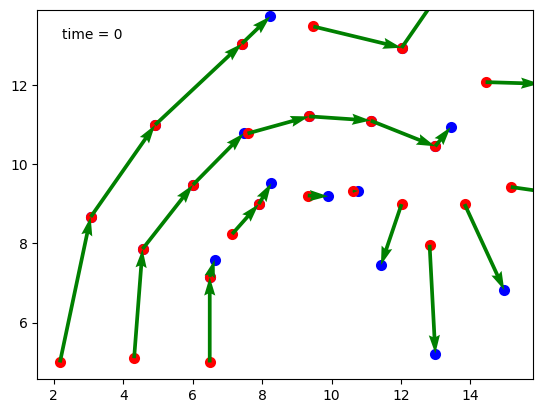

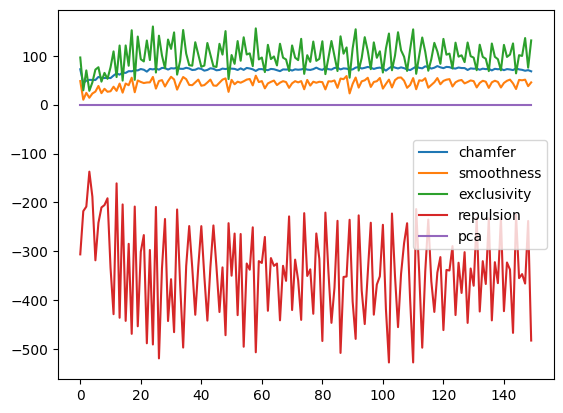

In [70]:
fig = plt.figure()
ax = plt.axes()  #xlim=(0, 30), ylim=(0,30))
scat = ax.scatter([], [], c='b', lw=2)
scat_from = ax.scatter([], [], c='r', lw=2)
time_text = ax.text(0.05, 0.95, '', horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)
initial_direction = padded_vectors_directions.clone().detach()
optimized_directions = padded_vectors_directions.clone().detach()
iteration_number = config["first_iteration_num"]
chamfer_losses = torch.zeros(iteration_number).detach()
vector_smoothness_losses = torch.zeros(iteration_number).detach()
exclusivity_losses = torch.zeros(iteration_number).detach()
repulsion_losses = torch.zeros(iteration_number).detach()
pca_losses = torch.zeros(iteration_number).detach()

shorten_centers = padded_centers_array.clone().detach()
shorten_centers = torch.narrow(shorten_centers, 0, 0, optimized_directions.shape[0])
Q = ax.quiver(shorten_centers[:, 0], shorten_centers[:, 1], optimized_directions[:, 0], optimized_directions[:, 1],
              scale=1, color='g', angles='xy', scale_units='xy')
xdata, ydata = [], []
one_active = True
                        
def animate(j):
    
    sum_of_losses = torch.tensor(0.0)
    optimizer.zero_grad()   
    #padded_vectors_directions = 
    optimized_directions = padded_vectors_directions.clone().detach()
    x = shorten_centers[:, 0] + optimized_directions[:, 0]
    y = shorten_centers[:, 1] + optimized_directions[:, 1]
    data = np.stack([x, y]).T
    scat.set_offsets(data)
    x_from = padded_centers_array[:, 0]
    y_from = padded_centers_array[:, 1]
    scat_from.set_offsets(np.c_[x_from, y_from])
    Q.set_UVC(optimized_directions[:, 0], optimized_directions[:, 1])
    for i in range(optimized_directions.shape[0]):
        mask = np.ones(padded_centers_array.shape[0], dtype=bool)
        mask[i] = False
        new_centers_array = padded_centers_array[mask].clone().detach()
        new_centers_array = new_centers_array.reshape(1, -1, 3)  # Reshape to (1, num_points, 3)
        centers_array_i = (padded_centers_array[i] + padded_vectors_directions[i]).reshape(1, -1, 3)
        chamfer_loss, _ = chamfer_distance(centers_array_i, new_centers_array, single_directional=True)
        sum_of_losses += chamfer_loss
    chamfer_losses[j] = config["LOSSES"]["chamfer"] * sum_of_losses
    smoothness = config["LOSSES"]["smoothness"] * calculate_differentiable_smoothness(padded_centers_array, padded_vectors_directions)
    exclusivity = config["LOSSES"]["exclusivity"] * vector_exclusivity(padded_centers_array, padded_vectors_directions)
    #pca_loss = 2*pca_differ(padded_vectors_directions, initial_direction)
    repulsion = config["LOSSES"]["repulsion"]*exclusivity_repulsion(padded_centers_array, padded_vectors_directions)

    vector_smoothness_losses[j] = smoothness
    exclusivity_losses[j] = exclusivity
    repulsion_losses[j] = repulsion
    #pca_losses[j] = pca_loss
    sum_of_losses += smoothness
    sum_of_losses += exclusivity
    sum_of_losses += repulsion    
    #sum_of_losses += pca_loss
    #print(sum_of_losses)
    sum_of_losses.backward()
    optimizer.step()
    time_text.set_text('time = %.1d' % j)
    return scat, scat_from

print()
anim = FuncAnimation(fig, animate, frames=iteration_number, interval=200)
anim.save("/home/komajz/PycharmProjects/FEL-matching-notebook/lane_marking/case" +str(case)+"/animation.gif", writer='imagemagick', fps=5)
plt.savefig("/home/komajz/PycharmProjects//FEL-matching-notebook/lane_marking/case"+str(case)+"/final.png")

fig = plt.figure()
plt.plot(chamfer_losses.detach().numpy(), label='chamfer')
plt.plot(vector_smoothness_losses.detach().numpy(), label='smoothness')
plt.plot(exclusivity_losses.detach().numpy(), label='exclusivity')
plt.plot(repulsion_losses.detach().numpy(), label='repulsion')
plt.plot(pca_losses.detach().numpy(), label='pca')
plt.legend()
plt.savefig("/home/komajz/PycharmProjects/FEL-matching-notebook/lane_marking/case"+str(case)+"/losses.png")
plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.


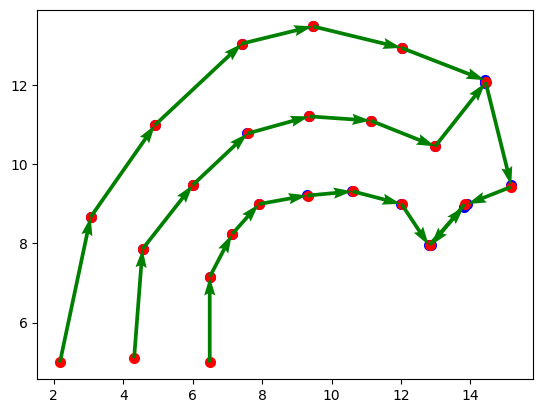

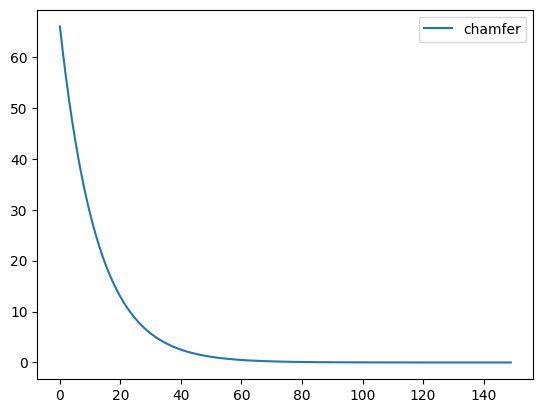

In [71]:
from matplotlib.animation import FuncAnimation

fig = plt.figure()
ax = plt.axes()  #xlim=(0, 30), ylim=(0,30))
scat = ax.scatter([], [], c='b', lw=2)
scat_from = ax.scatter([], [], c='r', lw=2)
optimized_directions = padded_vectors_directions.clone().detach()
chamfer_losses = torch.zeros(iteration_number).detach()
shorten_centers = padded_centers_array.clone().detach()
shorten_centers = torch.narrow(shorten_centers, 0, 0, optimized_directions.shape[0])
Q = ax.quiver(shorten_centers[:, 0], shorten_centers[:, 1], optimized_directions[:, 0], optimized_directions[:, 1],
              scale=1, color='g', angles='xy', scale_units='xy')
xdata, ydata = [], []


def animate(j):
    sum_of_losses = 0
    optimizer.zero_grad()

    optimized_directions = padded_vectors_directions.clone().detach()
    x = shorten_centers[:, 0] + optimized_directions[:, 0]
    y = shorten_centers[:, 1] + optimized_directions[:, 1]
    data = np.stack([x, y]).T
    scat.set_offsets(data)
    x_from = padded_centers_array[:, 0]
    y_from = padded_centers_array[:, 1]
    scat_from.set_offsets(np.c_[x_from, y_from])
    Q.set_UVC(optimized_directions[:, 0], optimized_directions[:, 1])

    for i in range(optimized_directions.shape[0]):
        mask = np.ones(padded_centers_array.shape[0], dtype=bool)
        mask[i] = False
        new_centers_array = padded_centers_array[mask].clone().detach()
        new_centers_array = new_centers_array.reshape(1, -1, 3)  # Reshape to (1, num_points, 3)
        centers_array_i = (padded_centers_array[i] + padded_vectors_directions[i]).reshape(1, -1, 3)
        chamfer_loss, _ = chamfer_distance(centers_array_i, new_centers_array, single_directional=True)
        sum_of_losses += chamfer_loss
    chamfer_losses[j] = sum_of_losses
    sum_of_losses.backward()
    optimizer.step()
    return scat, scat_from


anim = FuncAnimation(fig, animate, frames=config["second_iteration_num"], interval=200)
anim.save("/home/komajz/PycharmProjects/FEL-matching-notebook/lane_marking/case"+str(case)+"/animation1.gif", writer='imagemagick', fps=10)
fig = plt.figure()
plt.plot(chamfer_losses.detach().numpy(), label='chamfer')
plt.legend()
plt.show()